# Fast price approximator to time dependent derivatives

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, LeakyReLU, ELU, ReLU
from tensorflow.keras.optimizers import RMSprop

from keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

import time

## Monte-Carlo Simulation

Here we create a function to estimate the price of an Arithmetic Asian Call Option.

We start by simulating X paths for the underlying asset price under the equivalent martingale measure over 1 year with a daily time step, assuming that there are 22 business days in a month. Hence 22 × 12 = 264 business days in a year.

We then calculate the payoff of each simulation and find the price $C_t$ of the option.

$$ Payoffs = \left[ \frac{1}{n}\sum_{i=1}^{n}{S_{t_i}} - K \right]^+ $$

$$ C_t = e^{-rt}\mathbb{E}[Payoffs]$$

assuming the underlying price process is GBM.

In [2]:
def generate_option_price(S0, K, r, sigma, maturity, n_paths, rng: np.random._generator.Generator):
    """
    Function to generate data for asset prices and then calculate payoff and option price
    """

    T = maturity / 264      # Maturity in year (264 days per year)
    time_step = 1 / maturity
    
    logS = np.empty((maturity + 1, n_paths))  # Pre-allocation with an empty array
    
    logS[0,:] = np.log(S0)    # Initial log price
    
    m = r - .5 * sigma**2     # Expected log return
    
    # Geometric Brownian Motion:
    for i in range(1, maturity + 1):
        std_innov = rng.standard_normal(n_paths)
        logS[i, :] = logS[i - 1, :] + m * time_step + sigma * np.sqrt(time_step) * std_innov
        
    Simulated_prices = np.exp(logS)
    
    # Calulcate payoffs
    A = np.mean(Simulated_prices[1:,:], axis=0)
    Payoffs = np.maximum(A - K, 0)
     
    # Calculate Asian option price
    asian_option_price_mc = np.exp(-r * T) * np.mean(Payoffs)
    
    return asian_option_price_mc

With below codes we randomly generate 15000 values for our parameters, which are: asset prices at time 0, strikes, interest rates, volatilities and days to maturity. The range value for these parameters are set according to _Gan, lirong, Wang, Huamao and Yang, Zhaojun (2020)_. These parameters will play the role of independent variables (X) in our neural network model.

In [3]:
num_samples = 15000

np.random.seed(123)
S0 = np.random.uniform(10, 500, num_samples)  # Initial stock price, from 10 to 500 euros

np.random.seed(123)
K = np.random.randint(S0*0.8, S0*1.2, num_samples)  # Strike price, picked among 80% and 120% initial stock price

r_range = np.arange(0.01, 0.031, 0.001)  # Value range for Risk-free rate: 1% to 3%
sigma_range = np.arange(0.05, 0.901, 0.005)  # Value range for Volatility: 5% to 90%
maturity_range = np.arange(22, 793, 22) # Value range for Maturity: 1 month to 3 years, 22 days per month

# Choose randomly 15000 interest rates, volatilities and days to maturity in above value ranges
np.random.seed(123)
r = np.random.choice(r_range, num_samples) 

np.random.seed(123)
sigma = np.random.choice(sigma_range, num_samples)

np.random.seed(123)
maturity = np.random.choice(maturity_range, num_samples)

data = {
        'Initial Stock Prices': S0,
        'Strikes': K,
        'Risk-free Rates': r,
        'Volatility': sigma,
        'Maturity': maturity
    }

df = pd.DataFrame(data)
df.head()

,Initial Stock Prices,Strikes,Risk-free Rates,Volatility,Maturity
0,351.269901,390,0.023,0.595,66
1,150.208274,122,0.012,0.680,638
2,121.157212,124,0.012,0.380,770
3,280.144237,322,0.016,0.540,396
4,362.539795,307,0.027,0.135,440


Now we start to generate the prices of these Asian options using Monte Carlo method. For each option, we simulate 5000 scenarios and thus get 5000 payoffs. We then calculate the price based on these scenarios and get 1 price for each option. This will be our dependent variable (Y) in the neural network model.

In [4]:
np.random.seed(123)
rng = np.random.default_rng(seed=123)
n_paths = 5000
prices = []

start_time_MC = time.time() #record time we need to simulate using Monte Carlo method

for i in range(df.shape[0]):
    price = generate_option_price(df.iloc[i,0], df.iloc[i,1], df.iloc[i,2], df.iloc[i,3], df.iloc[i,4], n_paths, rng)
    prices.append(price)
    
end_time_MC = time.time()

We assign the independent variables and dependent variable to X and y respectively. We then scale X, and then divide the data into 3 parts: training set, validation set and testing set, with ratio 70/15/15.

In [5]:
df['Option Prices'] = prices
X, y = df[['Initial Stock Prices', 'Strikes', 'Risk-free Rates','Volatility', 'Maturity']], df[['Option Prices']]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)

## Building Neural Network

The optimal number of hidden layers being 4 is advocated by _Tugce Karatas, Amir Oskoui, Ali Hirsa (2019)_. This paper also proved that sigmoid and tanh are not suited for option pricing. Thus, 4 layers will be our choice for the Neural Networks.

Regarding the activation functions, _Gan, lirong, Wang, Huamao and Yang, Zhaojun (2020)_, suggested `LeakyReLU, ELU, ReLU` and `ELU` for Asian options. _Tugce Karatas, Amir Oskoui, Ali Hirsa (2019)_, on the other hand,suggested 4 `LeakyReLU` layers give the best result. But we also want to try a potential candidate for option pricing: `ReLU`, which is similar to the shape of option payoffs. Thus, we will try 3 models and pick out the one with the best result: First model with `LeakyReLU, ELU, ReLU` and `ELU`, second model with 4 `LeakyReLU` layers and the third model with 4 `ReLU` layers

For each hidden layer, we add a `Dropout` rate 0.25 to avoid overfitting. The loss function will be Mean Squared Error, a popular metric for model evaluation. At this step, the number of epochs are 10, because we don't want to overfit (epoch too high) or underfit (epoch too low). Optimizer and number of neurons are chosen as suggested in _Gan, lirong, Wang, Huamao and Yang, Zhaojun (2020)_. But to test other possibilities for our model, we will change these 2 parameters later and pick out the best ones.

In [6]:
start_train_NN = time.time() #recording training time using Neural Networks

def neural_network(neurons, Act_func1, Act_func2, Act_func3, Act_func4, epochs):
    """
    Function to build a neural network
    """
    
    model = Sequential()

    model.add(Dense(neurons, input_dim=X_train.shape[1]))
    model.add(Act_func1())
    model.add(Dropout(0.25))

    model.add(Dense(neurons))
    model.add(Act_func2())
    model.add(Dropout(0.25))

    model.add(Dense(neurons))
    model.add(Act_func3())
    model.add(Dropout(0.25))

    model.add(Dense(neurons))
    model.add(Act_func4())
    model.add(Dropout(0.25))

    model.add(Dense(1))

    model.compile(loss='mse',optimizer='rmsprop')

    history = model.fit(X_train, y_train, batch_size=64, epochs=epochs, validation_split=0.1, verbose=0)
    
    return model

In [7]:
def check_accuracy(y_test,y_pred):
    """
    Function to produce values for metrics to evaluate models
    (Mean squared error, Root Mean squared error, Mean absolute error and R-Squared)
    """
    y_test = np.array(y_test).flatten()
    y_pred = np.array(y_pred).flatten()
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return [mse, rmse, mae, r2]

### Activation Function selection

Now let's build our three models with aforementioned activation functions

In [8]:
model1 = neural_network(120, LeakyReLU, ELU, ReLU, ELU, 10)
model2 = neural_network(120, LeakyReLU, LeakyReLU, LeakyReLU, LeakyReLU, 10)
model3 = neural_network(120, ReLU, ReLU, ReLU, ReLU, 10)

Now let's use validation data to choose the best model among above three

In [9]:
y_val_model1 = model1.predict(X_val)
y_val_model2 = model2.predict(X_val)
y_val_model3 = model3.predict(X_val)

71/71 [==============================] - 0s 2ms/step


In [10]:
y_val_pred = np.concatenate((y_val_model1, y_val_model2, y_val_model3), axis=1)

In [11]:
#Check accuracy among 3 models
check_acc = []
for column in range(y_val_pred.shape[1]):
    accuracy = check_accuracy(y_val, y_val_pred[:, column])
    check_acc.append(accuracy)
    
df = pd.DataFrame(check_acc, columns = ['MSE', 'RMSE', 'MAE', 'R2'], index = ['Model 1', 'Model 2', 'Model 3'])
df

,MSE,RMSE,MAE,R2
Model 1,9.676030,3.110632,2.185134,0.986805
Model 2,4.663258,2.159458,1.648380,0.993641
Model 3,3.381441,1.838870,1.352239,0.995389


### Number of Neurons selection

In this step, we will see how many neurons we should use for our model. We will try a value range from 40 to 300 (with the step of 20).

In [12]:
neuron = np.arange(40,301,20)
loss = []
for i in neuron:
    model3_epoch = neural_network(i, ReLU, ReLU, ReLU, ReLU, 10)
    y_val_pre = model3_epoch.predict(X_val)
    model_val_loss = model3_epoch.evaluate(X_val, y_val)
    loss.append(model_val_loss)

71/71 [==============================] - 0s 3ms/step - loss: 7.1042


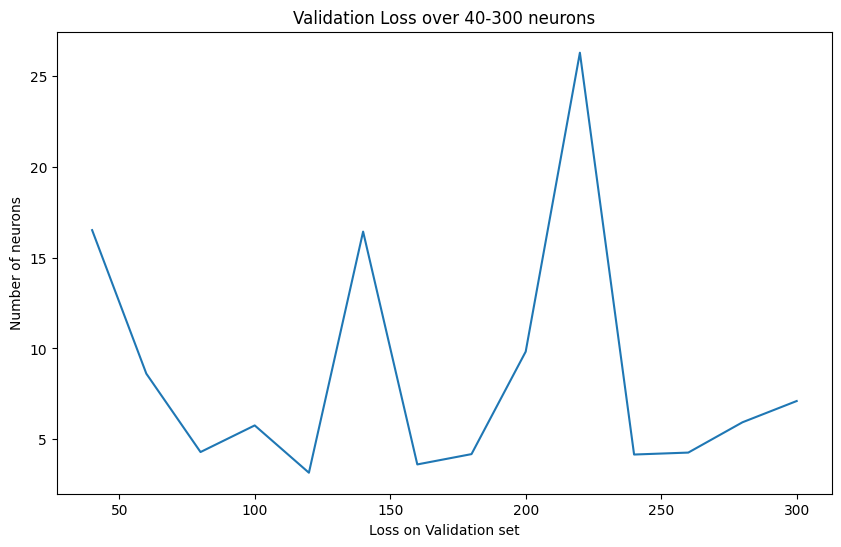

In [13]:
plt.figure(figsize=(10,6))
plt.plot(neuron, loss, '-')
plt.title('Validation Loss over 40-300 neurons')
plt.xlabel('Loss on Validation set')
plt.ylabel('Number of neurons')
plt.show()

### Number of Epochs selection

In this step, we will use the chosen activation functions and number of neurons to build a neural network with 500 epochs, and see how many epochs we should use to avoid overfitting and still get a reasonable loss.

In [14]:
neurons = 120
model = Sequential()

model.add(Dense(neurons, input_dim=X_train.shape[1]))
model.add(ReLU())
model.add(Dropout(0.25))

model.add(Dense(neurons))
model.add(ReLU())
model.add(Dropout(0.25))

model.add(Dense(neurons))
model.add(ReLU())
model.add(Dropout(0.25))

model.add(Dense(neurons))
model.add(ReLU())
model.add(Dropout(0.25))

model.add(Dense(1))

model.compile(loss='mse',optimizer='rmsprop')

history = model.fit(X_train, y_train, batch_size=64, epochs=500, validation_split=0.1, verbose=0)

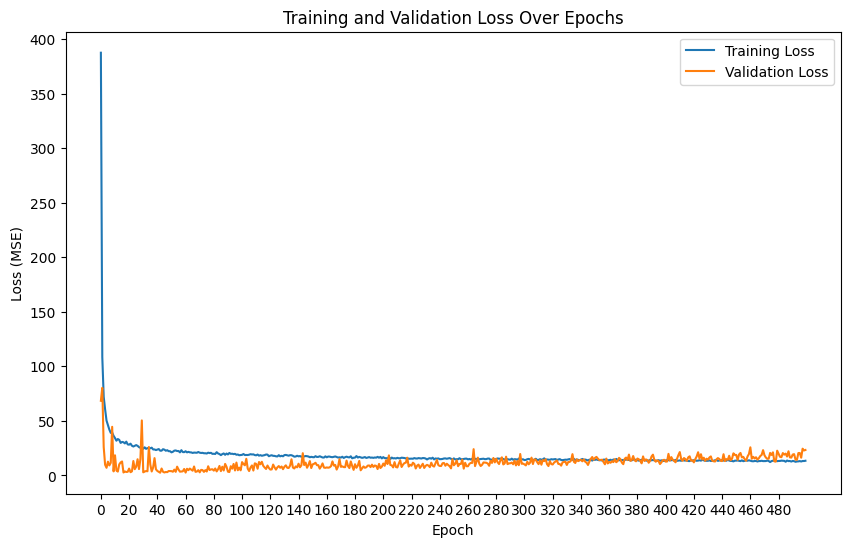

In [15]:
#Visualize the loss over numbers of epochs
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(10, 6))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
x_ticks = range(0, len(history_df), 20)
plt.xticks(x_ticks)
plt.show()

end_train_NN = time.time() #done training our Neural Networks model

### Final Model

To sum up, our final model will contain:
- 4 layers of `ReLU` activation function
- 120 neurons for each layer
- 20 epochs
Let's see how our model works on testing data set

In [16]:
final_model = neural_network(120, ReLU, ReLU, ReLU, ReLU, 20)

In [17]:
y_pred = final_model.predict(X_test)

71/71 [==============================] - 0s 2ms/step


In [18]:
final_accuracy = check_accuracy(y_test,y_pred)
print('Accuracy checking for final model:')
print(f"Mean Squared Error: {final_accuracy[0]:.2f}")
print(f"Root Mean Squared Error: {final_accuracy[1]:.2f}")
print(f"Mean Absolute Error: {final_accuracy[2]:.2f}")
print(f"R-squared: {final_accuracy[3]: .4f}")

Accuracy checking for final model:
Mean Squared Error: 5.45
Root Mean Squared Error: 2.33
Mean Absolute Error: 1.60
R-squared:  0.9929


The model produces good result with small errors and high R-squared value. Conclusion: the accuracy between our Neural Network model and Monte Carlo method is really high.

To see it better, let's visualize the out-of-sample comparison between Neural Network and Monte Carlo methods in predicting option prices.

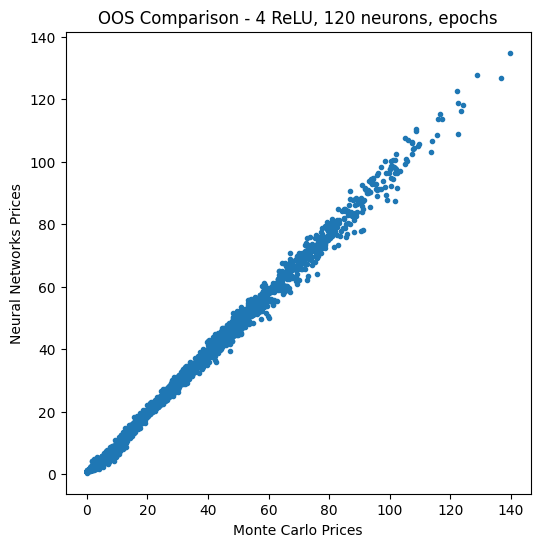

In [19]:
#Visualize
plt.figure(figsize = (6,6))
plt.plot(y_test, y_pred, '.')
plt.title('OOS Comparison - 4 ReLU, 120 neurons, epochs')
plt.xlabel('Monte Carlo Prices')
plt.ylabel('Neural Networks Prices')
plt.show()

## Evaluate the model on the Testing Dataset

### Compare speed of two methods

In [20]:
#we roughly estimate time for simulate prices for tesing set using Monte Carlo method
#roughly 1/5 time of simulating the whole data set

training_MC = (end_time_MC - start_time_MC)*0.85
testing_MC = (end_time_MC - start_time_MC)*0.15
training_NN = end_train_NN - start_train_NN

print(f'Runtime on Training and Validation data set using Monte Carlo is: {training_MC: .2f}')
print(f'Runtime to traing the Neural Network model is: {training_NN: .2f}')
print('------------------------------------------------------------------------')
print(f'Runtime on Testing data set using Monte Carlo is: {testing_MC: .2f}')

Runtime on Training and Validation data set using Monte Carlo is:  863.05
Runtime to traing the Neural Network model is:  530.14
------------------------------------------------------------------------
Runtime on Testing data set using Monte Carlo is:  152.30


### Compare Accuracy

As above